In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Gene2Vec Experiments
Attempting to recreate results of [gene2vec paper](https://doi.org/10.1186/s12864-018-5370-x)

#### 1. Import known gene pathways from [MSigDB](http://software.broadinstitute.org/gsea/msigdb/collections.jsp)

In [2]:
import pandas as pd
import gensim
import random

In [10]:
## word2vec parameters
dimension = 100     # dimension of the embedding
num_workers = 8     # number of worker threads
sg = 1              # sg =1, skip-gram, sg =0, CBOW
max_iter = 10       # number of iterations
window_size = 1     # The maximum distance between the gene and predicted gene within a gene list
negative = 3        # number of negative samples
txtOutput = True

# Environment variables
MSIGDB = '../data/msigdb.v6.2.symbols.gmt'
GENE2VEC_DIR = '../experiments/gene2vec/models/'
FILENAME = "gene2vec_dim_{0:d}_iter_".format(dimension)

In [3]:
def _get_data(line):
    name, _, genes = line.split("\t", 2)
    return name, set(i for i in genes.split("\t"))

with open(MSIGDB, 'r') as fp:
    pathways_df = pd.DataFrame(data=[_get_data(line) for line in fp],
                               columns=["name", "set"])

pathways_df.head()

,name,set
0,AAANWWTGC_UNKNOWN,"{CDH13, SATB2, MYH2, ZHX3, APP, THBS2, ZNF462,..."
1,AAAYRNCTG_UNKNOWN,"{NDUFS4, BCL2L1, PAPD5, ZIC1, CLTC, SEPT7, PMC..."
2,MYOD_01,"{STIM1, LNX2, UBXN10, PRKCQ, VKORC1L1, TMEM150..."
3,E47_01,"{CCL27, CHRDL1, MAP1A, PPP1R9B, VKORC1L1, RBPJ..."
4,CMYB_01,"{C14orf1, WDR90, MTF2, TIMP4, WDR78, PITX2, HE..."


#### 2. Generate pairs of genes from gene pathway sets

In [4]:
pathways_subset = pathways_df.head(1000).copy()

In [5]:
def generate_gene_pairs(gene_set):
    from itertools import combinations
    # Get all combinations of length 2 
    pairs = combinations(list(gene_set), 2)
    return set(pairs)

def get_pairs_set(df):
    """
    Return the set union of all pairs from every gene set within the df.
    """
    return set.union(*df['pairs'].tolist())

pathways_subset['pairs'] = (pathways_subset.set
                                           .apply(generate_gene_pairs))

# total set of pairs without any duplication across samples
total_set = pathways_subset.pipe(get_pairs_set)

In [6]:
len(total_set)

31365626

#### 3. Use [`gensim`](https://radimrehurek.com/gensim/models/word2vec.html) to train with gene2vec 
- With a c compile installed `gensim` offers a [70x speedup compared to plain NumPy implementation](https://rare-technologies.com/parallelizing-word2vec-in-python/)

In [ ]:
def train_word2vec(gene_pairs):
    # initialise and save model
    model = gensim.models.Word2Vec(gene_pairs, 
                                   size=dimension, 
                                   window=window_size, 
                                   min_count=1, 
                                   workers=num_workers, 
                                   max_iter=max_iter, 
                                   negative=negative,
                                   sg=sg)
    print("gene2vec model initialised")
    current_iter = 0
    model.save(GENE2VEC_DIR + FILENAME + str(current_iter))
    print("gene2vec model saved")
    del model 
    
    # train model
    for current_iter in range(1,max_iter+1):
        # shuffle pairs
        random.shuffle(gene_pairs)
        
        # load model and train on shuffled gene pairs
        model = gensim.models.Word2Vec.load(GENE2VEC_DIR + FILENAME + str(current_iter-1))
        model.train(gene_pairs,total_examples=model.corpus_count,epochs=model.iter)
        model.save(GENE2VEC_DIR + FILENAME + str(current_iter))
        print("gene2vec dimension " + str(dimension) + " iteration " + str(current_iter) + " start")
        del model
        
train_word2vec(list(total_set))

#### 4. Visualise embeddings with PCA and tSNE

In [11]:
# load model and train on shuffled gene pairs
current_iter = 9
filename = GENE2VEC_DIR + FILENAME + str(current_iter)

In [12]:
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
import random
from multiprocessing import Pool
from gensim.models.keyedvectors import KeyedVectors

def load_embeddings(file_name):
    model = KeyedVectors.load(file_name)
    wordVector = model.wv
    vocabulary, wv = zip(*[[word, wordVector[word]] for word, vocab_obj in wordVector.vocab.items()])
    return np.asarray(wv), vocabulary

# load test file
wv, vocabulary = load_embeddings(filename)

# shuffle index of genes
indexes = list(range(len(wv)))
random.shuffle(indexes)

topN = len(wv) # for now select all genes
rdWV = wv[indexes][:topN][:]
rdVB = np.array(vocabulary)[indexes][:topN]

In [13]:
print(wv.shape, rdWV.shape, rdVB.shape)

(14812, 100) (14812, 100) (14812,)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

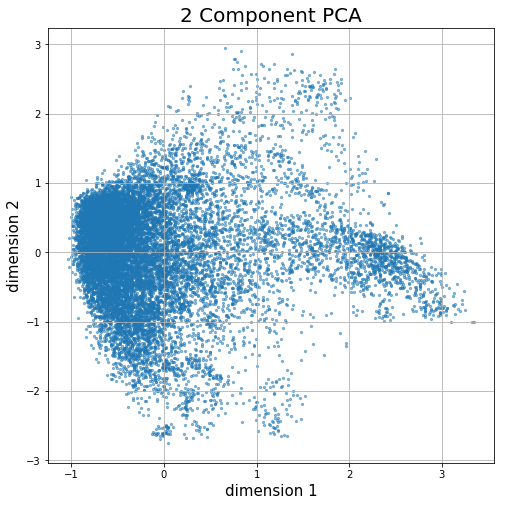

In [25]:
def plot_2d(data, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('dimension 1', fontsize = 15)
    ax.set_ylabel('dimension 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    
    ax.scatter(data[:,0], data[:,1], s = 5, alpha=0.5)
    ax.grid()

# 2 component PCA visualisation
pca_2 = PCA(n_components=2)
pca_2.fit(rdWV)
pca_rdWV_2=pca_2.transform(rdWV)

# plot
plot_2d(pca_rdWV_2, title='2 Component PCA')

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

n_iter = 100 started
n_iter = 10000 started
n_iter = 1000 started
n_iter = 100 finished
n_iter = 1000 finished
n_iter = 10000 finished


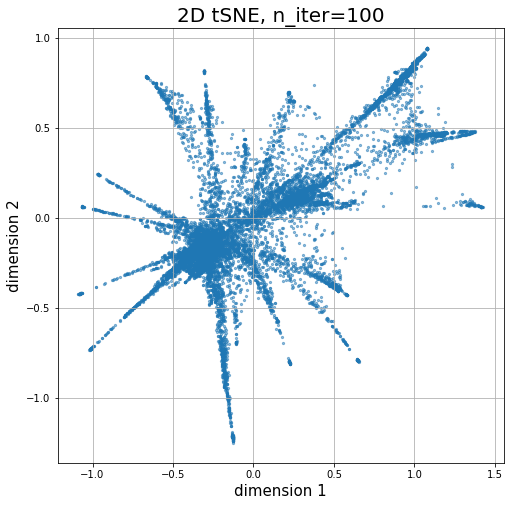

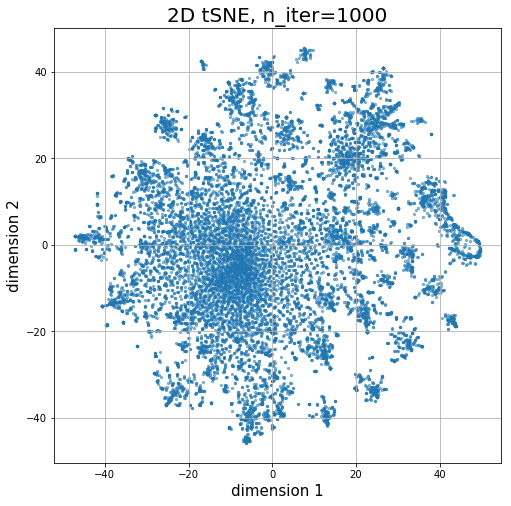

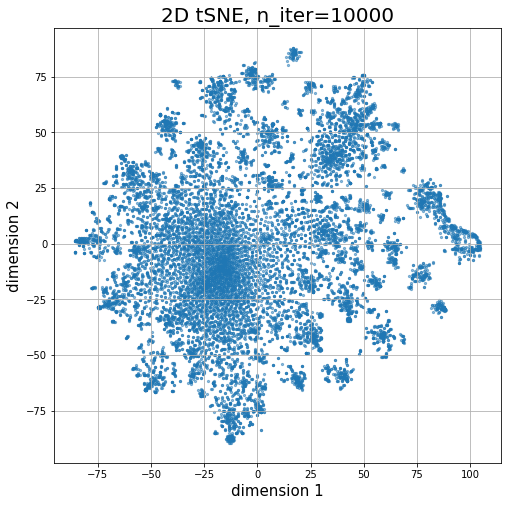

In [34]:
# 50 component PCA for tSNE
pca = PCA(n_components=50)
pca.fit(rdWV)
pca_rdWV=pca.transform(rdWV)

def tsne_worker(n_iter):
    # 2 component tSNE applied to PCA
    tsne = TSNE(n_components=2, 
                perplexity=30, 
                n_iter=n_iter, 
                learning_rate=200, 
                n_jobs=8)
    
    print('n_iter = {0:d} started'.format(n_iter))
    data = tsne.fit_transform(pca_rdWV)
    print('n_iter = {0:d} finished'.format(n_iter))
    return data, n_iter
    
p = Pool(4)
    
#generate tsne of different iteration in parallel
results = p.map(tsne_worker, [100, 1000, 10000]) 

# plot tSNE
for data, n_iter in results:
    plot_2d(data, '2D tSNE, n_iter={0:d}'.format(n_iter))

In [ ]:
#### 5. Download and preprocess somatic mutations from [TCGA in BigQuery]()